In [157]:
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.log.obj import EventLog, Trace, Event

from pm4py.algo.discovery.inductive import algorithm as inductive_miner


In [158]:
log = xes_importer.apply('logs/data/log-5-percent-noise.xes.gz')

parsing log, completed traces ::   0%|          | 0/100000 [00:00<?, ?it/s]

In [159]:
log

[{'attributes': {'concept:name': '1'}, 'events': [{'concept:name': 'Triage', 'lifecycle:transition': 'complete', 'priority': 'green', 'time:timestamp': datetime.datetime(1970, 1, 1, 1, 0, tzinfo=datetime.timezone.utc)}, '..', {'concept:name': 'Prepare', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(1970, 1, 1, 2, 19, tzinfo=datetime.timezone.utc)}]}, '....', {'attributes': {'concept:name': '99999'}, 'events': [{'concept:name': 'Triage', 'lifecycle:transition': 'complete', 'priority': 'orange', 'time:timestamp': datetime.datetime(1987, 2, 5, 17, 56, tzinfo=datetime.timezone.utc)}, '..', {'concept:name': 'Prepare', 'lifecycle:transition': 'complete', 'time:timestamp': datetime.datetime(1987, 2, 5, 19, 35, tzinfo=datetime.timezone.utc)}]}]

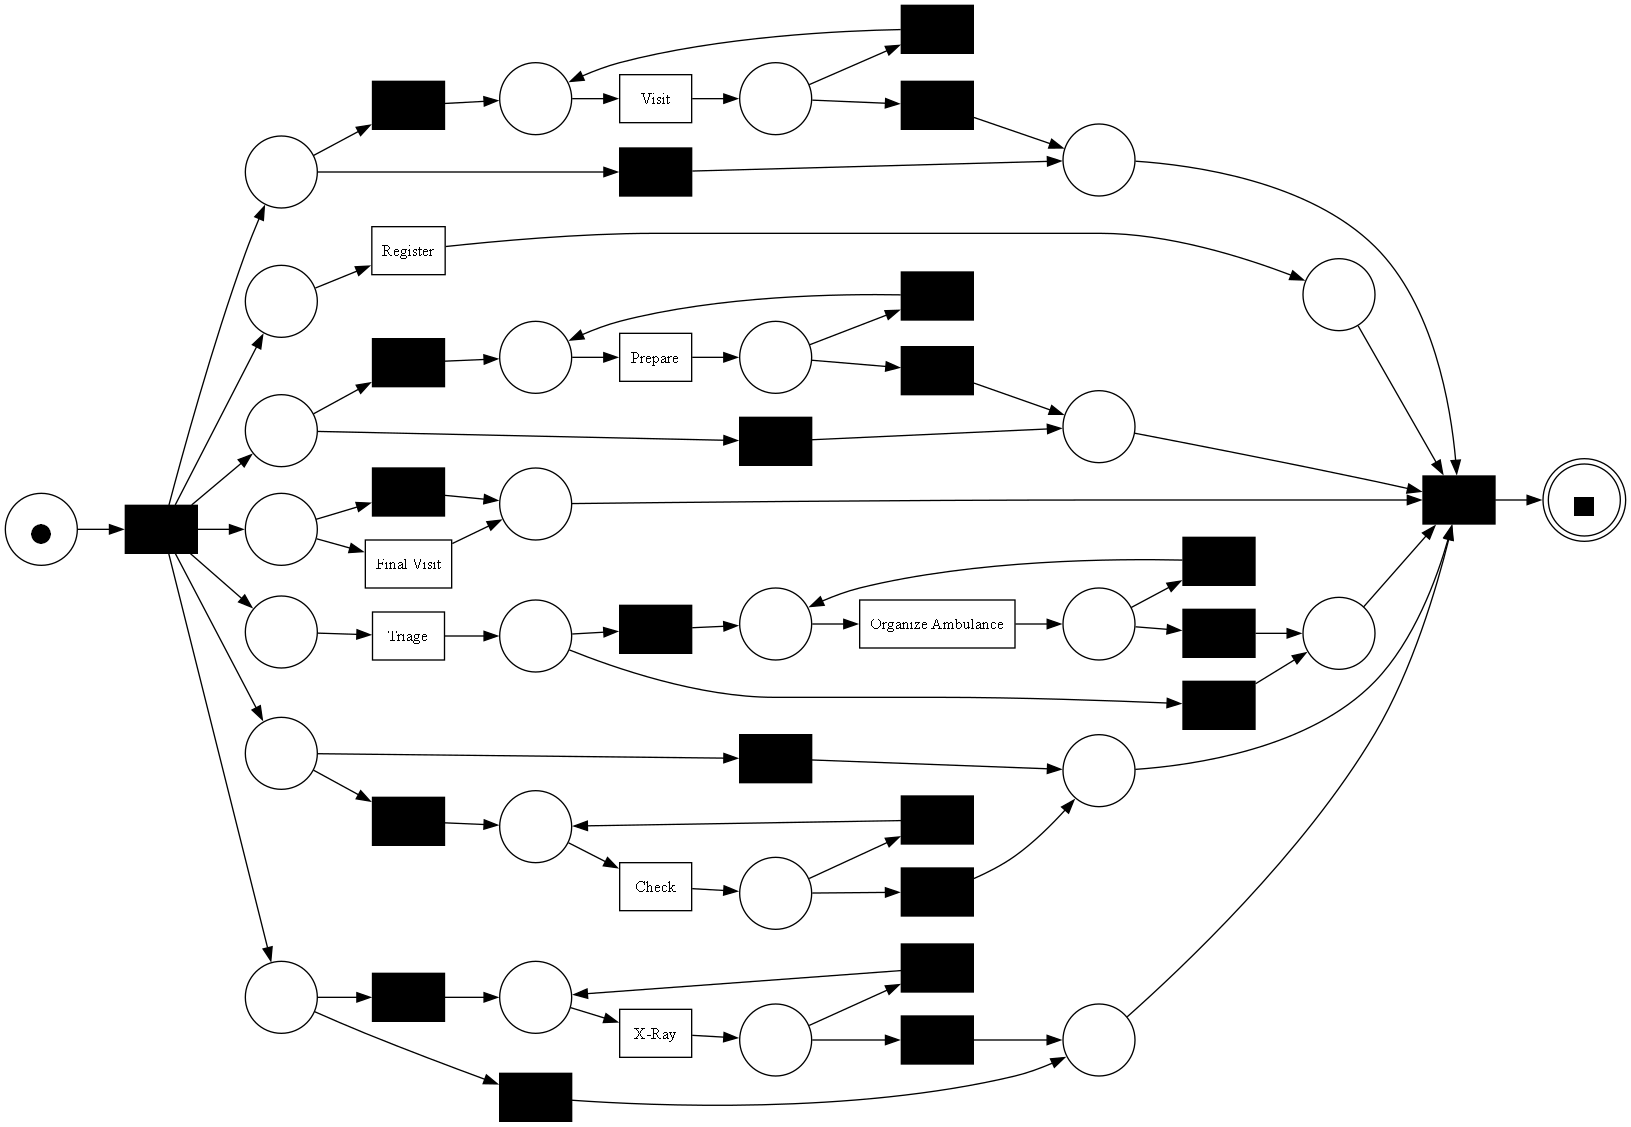

Petri net estratta!
Num places: 27
Num transitions: 31
#arcs: 74
initial_marking: ['source:1']
final_marking: ['sink:1']


In [160]:
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log) #inductive miner

pm4py.view_petri_net(net, initial_marking, final_marking)

print("Petri net estratta!")
print("Num places:", len(net.places))
print("Num transitions:", len(net.transitions))
print("#arcs:", len(net.arcs))
print("initial_marking:", initial_marking)
print("final_marking:", final_marking)

In [161]:
params = {"ret_tuple_as_trans_desc": True}

In [162]:
from pm4py.algo.conformance.alignments.petri_net import algorithm as align_algo
params = {"ret_tuple_as_trans_desc": True}
# Perform alignments
alns = align_algo.apply_log(log, net, initial_marking, final_marking, parameters=params)


aligning log, completed variants ::   0%|          | 0/1440 [00:00<?, ?it/s]

In [163]:

print("alignments calcolati:", len(alns ))
print("esempio keys:", alns[0].keys())
print("costo primo:", alns[0]["cost"])

alignments calcolati: 100000
esempio keys: dict_keys(['alignment', 'cost', 'visited_states', 'queued_states', 'traversed_arcs', 'lp_solved', 'fitness', 'bwc'])
costo primo: 12


In [191]:
from pm4py.objects.log.obj import EventLog, Trace, Event

ACT_KEY = "concept:name"
def is_silent_model_move(bi):
    # bi può essere None, ">>", una tupla, o un oggetto Transition
    if bi is None or bi == ">>":
        return True
    # se è una tupla tipo (name,label) o simili
    if isinstance(bi, tuple) and len(bi) >= 2:
        return bi[1] is None or bi[1] == ">>"
    # se è una Transition PM4Py
    if hasattr(bi, "label"):
        return bi.label is None
    return False

def model_move_label(bi):
    if bi is None or bi == ">>":
        return None
    if isinstance(bi, str):
        return bi
    if isinstance(bi, tuple) and len(bi) >= 2:
        return bi[1]   # spesso è la label
    if hasattr(bi, "label"):
        return bi.label
    return str(bi)

def is_dummy_event(ev):
    return ev.get("_dummy_label", False) is True


def build_aligned_log_from_alignments(log, alignments_desc, activity_key=ACT_KEY):
    """
    Versione compatibile con alignments ottenuti con:
      parameters={"ret_tuple_as_trans_desc": True}

    Ogni mossa mv è:
      mv = ((log_side, transition_name), (model_side, label_or_None))

    Regole PDF:
      - sync (e_j, t_l) con stessa label -> tieni evento originale
      - move on model non-silent (>>, t_l) -> inserisci dummy event (label=lab, dummy label/timestamp)
      - silent move on model (>>, t_l) con lab=None -> ignora
      - move on trace (e_j, >>) -> rimuovi evento (consuma j)
    """
    aligned_log = EventLog()

    for tr, al in zip(log, alignments_desc):
        moves = al.get("alignment", [])
        tA = Trace()
        if hasattr(tr, "attributes"):
            tA.attributes.update(dict(tr.attributes))

        j = 0  # indice negli eventi originali

        for mv in moves:
            # mv deve essere: ((log_side, tname), (model_side, lab))
            (log_side, tname), (model_side, lab) = mv

            # 1) move-on-trace: consumi un evento del log, ma il modello non fa una transizione visibile corrispondente
            # Nel formato desc spesso appare come: (log_side != '>>', lab is None)
            if log_side != ">>" and lab is None:
                j += 1
                continue

            # 2) sync move: evento del log + transizione visibile del modello (lab non None)
            if log_side != ">>" and lab is not None:
                # copia l'evento originale (mantiene timestamp e attributi)
                ev = Event(dict(tr[j]))
                # (opzionale ma utile) assicurati che concept:name corrisponda alla label del modello
                ev[activity_key] = lab
                tA.append(ev)
                j += 1
                continue

            # 3) move-on-model: log_side == '>>'
            if log_side == ">>":
                # silent (tau): lab None -> ignora
                if lab is None:
                    continue

                # non-silent: inserisci dummy event
                ev = Event()
                ev[activity_key] = str(lab)
                ev["_dummy_label"] = True
                ev["_dummy_timestamp"] = True
                tA.append(ev)
                continue

            # fallback safety: se succede qualcosa di inatteso, consumiamo evento
            if log_side != ">>":
                j += 1

        aligned_log.append(tA)

    return aligned_log



In [192]:
aligned_log = build_aligned_log_from_alignments(log, alns)
print("aligned_log traces:", len(aligned_log))
lens = [len(tr) for tr in aligned_log]
print("min/mean/max len:", min(lens), sum(lens)/len(lens), max(lens))
print("first aligned trace length:", len(aligned_log[0]))
print("unique aligned traces:",
      len(set(tuple(ev["concept:name"] for ev in tr) for tr in aligned_log)))



aligned_log traces: 100000
min/mean/max len: 2 8.98632 12
first aligned trace length: 8
unique aligned traces: 1440


In [193]:


perfect_alns = align_algo.apply_log(aligned_log, net, initial_marking, final_marking, parameters=params)

print("perfect_alignments:", len(perfect_alns))
print("prime 10 mosse perfect:", perfect_alns[0]["alignment"][:10])


aligning log, completed variants ::   0%|          | 0/1440 [00:00<?, ?it/s]

perfect_alignments: 100000
prime 10 mosse perfect: [(('>>', 'tau_1'), ('>>', None)), (('>>', 'init_loop_22'), ('>>', None)), (('>>', 'init_loop_27'), ('>>', None)), (('>>', 'init_loop_11'), ('>>', None)), (('>>', 'init_loop_6'), ('>>', None)), (('t_Triage_0', '1664dee0-458c-4e78-a832-9a8368051b61'), ('Triage', 'Triage')), (('>>', 'skip_16'), ('>>', None)), (('t_Register_1', 'b1e4a8a2-76c6-441d-85e7-26f2b13dd218'), ('Register', 'Register')), (('t_Check_2', 'fa6e0b59-c6df-417c-b596-20b3a17a63af'), ('Check', 'Check')), (('>>', 'skip_8'), ('>>', None))]


perfect_alignments: 100000
prime 10 mosse perfect: [('>>', None), ('>>', None), ('>>', None), ('Triage', 'Triage'), ('Register', 'Register'), ('>>', None), ('>>', None), ('>>', None), ('>>', None), ('>>', None)]

In [194]:
print(perfect_alns[0]["alignment"][:10])
print(type(perfect_alns[0]["alignment"][0][1]))


[(('>>', 'tau_1'), ('>>', None)), (('>>', 'init_loop_22'), ('>>', None)), (('>>', 'init_loop_27'), ('>>', None)), (('>>', 'init_loop_11'), ('>>', None)), (('>>', 'init_loop_6'), ('>>', None)), (('t_Triage_0', '1664dee0-458c-4e78-a832-9a8368051b61'), ('Triage', 'Triage')), (('>>', 'skip_16'), ('>>', None)), (('t_Register_1', 'b1e4a8a2-76c6-441d-85e7-26f2b13dd218'), ('Register', 'Register')), (('t_Check_2', 'fa6e0b59-c6df-417c-b596-20b3a17a63af'), ('Check', 'Check')), (('>>', 'skip_8'), ('>>', None))]
<class 'tuple'>


In [195]:

# def is_pdf_perfect(al):
#     for (ai, bi) in al["alignment"]:
#         if ai == ">>":
#             # consentito solo se silent
#             if not is_silent_model_move(bi):
#                 return False
#         else:
#             # ai è evento reale: deve essere sync, quindi model label uguale
#             if model_move_label(bi) != ai:
#                 return False
#     return True

# print("pdf-perfect:", sum(is_pdf_perfect(a) for a in perfect_alns), "/", len(perfect_alns))


In [196]:
# print("Costi alignment:")
# print(set(al["cost"] for al in perfect_alns))


In [197]:
# def pdf_cost(al):
#     c = 0
#     for (ai, bi) in al["alignment"]:
#         # move on trace (ej, >>)
#         if ai != ">>" and (bi is None or bi == ">>"):
#             c += 1
#         # move on model non-silent (>>, tl) con tl != tau
#         if ai == ">>" and (bi is not None and bi != ">>"):
#             c += 1
#         # silent (>>, tau) cioè bi None o ">>" -> costo 0
#     return c

# print("Costi PM4Py:", set(a["cost"] for a in perfect_alns))
# print("Costi secondo PDF:", {pdf_cost(a) for a in perfect_alns})


In [198]:
# import numpy as np

# silent_counts = [sum(1 for (ai,bi) in a["alignment"] if ai == ">>" and (bi is None or bi=="<<")) for a in perfect_alignments]
# print("Silent moves per trace: min/mean/max =", min(silent_counts), np.mean(silent_counts), max(silent_counts))

# sync_counts = [sum(1 for (ai,bi) in a["alignment"] if ai != ">>") for a in perfect_alns]
# print("Sync moves per trace: min/mean/max =", min(sync_counts), np.mean(sync_counts), max(sync_counts))


# [DEBUG] A(tA) contains only synchronized moves and silent moves

In [219]:
def _extract_labels_from_move(mv):
    """
    Ritorna (log_label, model_label, is_silent)
    Supporta diversi formati PM4Py:
      A) ((log_side, tname), (model_side, lab))  [lab None => silent]
      B) ((t_desc, tname), (log_lbl, log_lbl))   [sync]
      C) (('tau_x', ...), ('>>', None))          [silent]
    """
    if not (isinstance(mv, tuple) and len(mv) == 2):
        return None, None, None

    left, right = mv

    # helper: prende "label" dalla coppia (a,b) se sembra una label
    def norm_label(x):
        if x is None:
            return None
        if isinstance(x, str):
            return x
        return str(x)

    # Caso A: right = (model_side, lab)
    if isinstance(left, tuple) and len(left) == 2 and isinstance(right, tuple) and len(right) == 2:
        a0, a1 = left
        b0, b1 = right

        # Se b0 è ">>" e b1 è None o stringa: tipico model-side in formato A
        if b0 == ">>":
            log_label = None  # nel formato A il log-side spesso è '>>' o non contiene label
            model_label = b1  # label modello (None per silent)
            is_silent = (b1 is None)
            return log_label, model_label, is_silent

        # Caso B: right = ('Triage','Triage') => sync, quindi log_label = b0, model_label = b1
        # (oppure viceversa, ma qui sono uguali)
        if isinstance(b0, str) and isinstance(b1, str) and b0 == b1:
            log_label = b0
            model_label = b1
            is_silent = False
            return log_label, model_label, is_silent

        # Silent stile: right = ('>>', None)
        if b0 == ">>" and b1 is None:
            return ">>", None, True

        # fallback: prova a interpretare come (log_label, model_label)
        return norm_label(b0), norm_label(b1), (b0 == ">>" or b1 is None)

    return None, None, None


def verify_perfect_alignments_robust(perfect_alignments, max_examples=8):
    total = len(perfect_alignments)
    bad = 0

    cnt_sync = 0
    cnt_silent = 0
    cnt_bad = 0

    examples = []

    for idx, al in enumerate(perfect_alignments):
        moves = al.get("alignment", [])
        ok = True

        for mv in moves:
            log_label, model_label, is_silent = _extract_labels_from_move(mv)

            # silent move OK
            if is_silent:
                cnt_silent += 1
                continue

            # sync OK se labels coincidono e non sono '>>'
            if log_label is not None and model_label is not None and log_label == model_label and log_label != ">>":
                cnt_sync += 1
                continue

            ok = False
            cnt_bad += 1
            if len(examples) < max_examples:
                examples.append((idx, mv, (log_label, model_label, is_silent)))

        if not ok:
            bad += 1

    print(f"Perfect alignments checked: {total}")
    print(f"Alignments NOT perfect: {bad} ({bad/total:.2%})\n")
    print("Move counts (global):")
    print(f"  sync moves:   {cnt_sync}")
    print(f"  silent moves: {cnt_silent}")
    print(f"  bad/unknown:  {cnt_bad}\n")

    if bad > 0 and examples:
        print("Examples (alignment_index, raw_move, parsed(log_label, model_label, is_silent)):")
        for e in examples:
            print(" ", e)

    return bad == 0

# run
is_perfect = verify_perfect_alignments_robust(perfect_alns, max_examples=8)
print("\nALL PERFECT?", is_perfect)


Perfect alignments checked: 100000
Alignments NOT perfect: 0 (0.00%)

Move counts (global):
  sync moves:   898632
  silent moves: 1301532
  bad/unknown:  0


ALL PERFECT? True


Perfect alignments checked: 100000
Alignments NOT perfect: 0 (0.00%)

Move counts (global):
  sync moves (visible label): 200000
  silent moves (label None):  700000
  other/weird:                0


ALL PERFECT? True

# ======================

# AUTOMATA

In [200]:
import random
from pm4py.objects.petri_net.semantics import ClassicSemantics
from pm4py.objects.petri_net.obj import Marking

SEM = ClassicSemantics()

class AutomataLearningWrapper:
    """
    Wrapper PDF-coerente:
    - reset(): random perfect alignment, marking=initial, index=1
    - step(): ritorna (transition_at_index, marking_after_firing) e incrementa index
             se finito -> ritorna solo final_marking
    Usa il transition_name presente nel perfect alignment (ret_tuple_as_trans_desc=True).
    """
    def __init__(self, net, initial_marking, final_marking, perfect_alignments, seed=None):
        self.net = net
        self.initial_marking = initial_marking
        self.final_marking = final_marking
        self.perfect_alignments = perfect_alignments
        self._rng = random.Random(seed)

        # mappa name->Transition (univoca)
        self.trans_by_name = {t.name: t for t in net.transitions}

        self.moves = None
        self.marking = None
        self.pos = None

    @property
    def index(self):
        return None if self.pos is None else self.pos + 1  # 1-based

    def reset(self):
        al = self._rng.choice(self.perfect_alignments)
        self.moves = al.get("alignment", [])
        self.marking = Marking(self.initial_marking)
        self.pos = 0
        return Marking(self.marking)

    def _transition_name_at_pos(self, pos):
        """
        Ogni entry è tipo: ((log_side, transition_name), (model_side, label_or_None))
        Noi prendiamo transition_name.
        """
        (log_side, tname), (model_side, _lab) = self.moves[pos]
        return tname

    def step(self):
        if self.moves is None:
            raise RuntimeError("Call reset() before step().")

        if self.pos >= len(self.moves):
            return Marking(self.final_marking)

        tname = self._transition_name_at_pos(self.pos)
        if tname not in self.trans_by_name:
            raise RuntimeError(f"Transition name '{tname}' not found in net.transitions")

        t = self.trans_by_name[tname]

        enabled = set(SEM.enabled_transitions(self.net, self.marking))
        if t not in enabled:
            raise RuntimeError(
                f"Alignment transition not enabled at pos={self.pos}, t={t.name}/{t.label}, marking={self.marking}"
            )

        self.marking = SEM.execute(t, self.net, self.marking)
        self.pos += 1
        return t, Marking(self.marking)

    def is_done(self):
        return self.moves is not None and self.pos is not None and self.pos >= len(self.moves)


In [201]:
env = AutomataLearningWrapper(net, initial_marking, final_marking, perfect_alns, seed=42)

m0 = env.reset()
print("Reset:", m0, "index:", env.index)
for _ in range(10):
    out = env.step()
    if isinstance(out, tuple):
        t, m = out
        print("Step:", (str(getattr(t, "name", t)), getattr(t, "label", None)), m, "index:", env.index)
    else:
        print("Final:", out)

while not env.is_done():
    env.step()

print("Final return:", env.step())  # solo final_marking
print("Reached marking:", env.marking)
print("Final marking:", final_marking)


Reset: ['source:1'] index: 1
Step: ('tau_1', None) ['p_10:1', 'p_15:1', 'p_17:1', 'p_19:1', 'p_25:1', 'p_30:1', 'p_5:1'] index: 2
Step: ('init_loop_11', None) ['p_12:1', 'p_15:1', 'p_17:1', 'p_19:1', 'p_25:1', 'p_30:1', 'p_5:1'] index: 3
Step: ('init_loop_6', None) ['p_12:1', 'p_15:1', 'p_17:1', 'p_19:1', 'p_25:1', 'p_30:1', 'p_7:1'] index: 4
Step: ('init_loop_22', None) ['p_12:1', 'p_15:1', 'p_17:1', 'p_19:1', 'p_27:1', 'p_30:1', 'p_7:1'] index: 5
Step: ('init_loop_27', None) ['p_12:1', 'p_15:1', 'p_17:1', 'p_19:1', 'p_27:1', 'p_32:1', 'p_7:1'] index: 6
Step: ('1664dee0-458c-4e78-a832-9a8368051b61', 'Triage') ['p_12:1', 'p_15:1', 'p_17:1', 'p_21:1', 'p_27:1', 'p_32:1', 'p_7:1'] index: 7
Step: ('skip_16', None) ['p_12:1', 'p_15:1', 'p_17:1', 'p_20:1', 'p_27:1', 'p_32:1', 'p_7:1'] index: 8
Step: ('b1e4a8a2-76c6-441d-85e7-26f2b13dd218', 'Register') ['p_12:1', 'p_16:1', 'p_17:1', 'p_20:1', 'p_27:1', 'p_32:1', 'p_7:1'] index: 9
Step: ('fab7cc28-e755-4c1d-88b8-9aac5b1e9f81', 'X-Ray') ['p_13

# ASSIGNMENT 2

In [202]:
from collections import defaultdict
SEM = ClassicSemantics()

def marking_key(m: Marking):
    """Chiave hashabile per una marking."""
    return tuple(sorted((p.name, int(c)) for p, c in m.items()))

def build_markov_from_perfect_alignments(net, initial_marking, perfect_alns, trace_weight=None):
    """
    Costruisce:
      - visits[q]: conteggio visite allo stato q (q identificato da marking_key)
      - trans_counts[q][tname]: conteggi transizioni uscenti da q
      - total_steps: somma totale dei passi (per P(Q))
    trace_weight: opzionale dict {trace_index: peso} (per molteplicità). Se None -> peso 1.
    """
    trans_by_name = {t.name: t for t in net.transitions}

    visits = defaultdict(float)
    trans_counts = defaultdict(lambda: defaultdict(float))
    total_steps = 0.0

    for i, al in enumerate(perfect_alns):
        w = 1.0 if trace_weight is None else float(trace_weight.get(i, 1.0))
        moves = al.get("alignment", [])

        m = Marking(initial_marking)

        for mv in moves:
            # mv: ((log_side, transition_name), (model_side, label_or_None))
            (log_side, tname), (model_side, lab) = mv

            q = marking_key(m)
            visits[q] += w

            t = trans_by_name[tname]
            trans_counts[q][tname] += w

            m = SEM.execute(t, net, m)
            total_steps += w

    return visits, trans_counts, total_steps

Probabilità di transizione e H(Q)

In [203]:
import math
def compute_state_entropy_and_probs(visits, trans_counts):
    """
    Ritorna:
      - out_probs[q]: dict tname -> p
      - Hq[q]: entropy dello stato
    """
    out_probs = {}
    Hq = {}

    for q, outs in trans_counts.items():
        tot = sum(outs.values())
        probs = {tname: c/tot for tname, c in outs.items()}
        out_probs[q] = probs

        h = 0.0
        for p in probs.values():
            h -= p * math.log2(p)
        Hq[q] = h

    return out_probs, Hq


P(Q) e H(Process)

In [204]:
def compute_process_entropy(visits, Hq, total_steps):
    Pq = {q: v/total_steps for q, v in visits.items()}
    H_process = sum(Pq[q] * Hq.get(q, 0.0) for q in Pq.keys())
    return Pq, H_process


In [205]:
visits, trans_counts, total_steps = build_markov_from_perfect_alignments(
    net, initial_marking, perfect_alns
)

out_probs, Hq = compute_state_entropy_and_probs(visits, trans_counts)
Pq, H_process = compute_process_entropy(visits, Hq, total_steps)

print("num states:", len(visits))
print("total steps:", total_steps)
print("H(Process):", H_process)


num states: 555
total steps: 2200164.0
H(Process): 0.7121856647049901


In [206]:
def debug_global_checks(visits, trans_counts, out_probs, Hq, Pq, total_steps):
    print("=== GLOBAL CHECKS ===")
    print("num states:", len(visits))
    print("num states with outgoing transitions:", len(trans_counts))
    print("total_steps:", total_steps)

    # somma visite = total steps? (dovrebbe essere uguale se conti una visita per step)
    sum_visits = sum(visits.values())
    print("sum(visits):", sum_visits, "  (should equal total_steps)")

    # somma P(Q)
    sum_pq = sum(Pq.values())
    print("sum(P(Q)):", sum_pq, "  (should be 1.0)")

    # check distribuzioni uscenti
    bad = 0
    for q, probs in out_probs.items():
        s = sum(probs.values())
        if abs(s - 1.0) > 1e-9:
            bad += 1
    print("states with outgoing probs sum != 1:", bad)

    # range entropy
    if Hq:
        print("H(Q) min/max:", min(Hq.values()), "/", max(Hq.values()))
    print("=====================\n")


In [207]:
def debug_global_checks(visits, trans_counts, out_probs, Hq, Pq, total_steps):
    print("=== GLOBAL CHECKS ===")
    print("num states:", len(visits))
    print("num states with outgoing transitions:", len(trans_counts))
    print("total_steps:", total_steps)

    # somma visite = total steps? (dovrebbe essere uguale se conti una visita per step)
    sum_visits = sum(visits.values())
    print("sum(visits):", sum_visits, "  (should equal total_steps)")

    # somma P(Q)
    sum_pq = sum(Pq.values())
    print("sum(P(Q)):", sum_pq, "  (should be 1.0)")

    # check distribuzioni uscenti
    bad = 0
    for q, probs in out_probs.items():
        s = sum(probs.values())
        if abs(s - 1.0) > 1e-9:
            bad += 1
    print("states with outgoing probs sum != 1:", bad)

    # range entropy
    if Hq:
        print("H(Q) min/max:", min(Hq.values()), "/", max(Hq.values()))
    print("=====================\n")


In [208]:
def pretty_marking_key(q_key):
    # q_key è tipo: (('p_10',1), ('p_22',1), ...)
    return "{" + ", ".join([f"{p}:{c}" for p, c in q_key]) + "}"

def debug_print_state(q, visits, trans_counts, out_probs, Hq, Pq, topk=10):
    print("STATE Q (marking):", pretty_marking_key(q))
    print("  P(Q):", Pq.get(q, 0.0))
    print("  visits:", visits.get(q, 0.0))
    print("  H(Q):", Hq.get(q, 0.0))

    outs = trans_counts.get(q, {})
    if not outs:
        print("  (no outgoing transitions recorded)")
        return

    # ordina per prob
    probs = out_probs[q]
    top = sorted(probs.items(), key=lambda kv: kv[1], reverse=True)[:topk]
    print("  Top outgoing transitions:")
    for tname, p in top:
        print(f"    - {tname}: p={p:.4f}, count={outs[tname]}")
    print()


In [209]:
def top_states_by_visit(visits, n=5):
    return [q for q, _ in sorted(visits.items(), key=lambda kv: kv[1], reverse=True)[:n]]


In [210]:
def top_states_by_entropy(Hq, n=5):
    return [q for q, _ in sorted(Hq.items(), key=lambda kv: kv[1], reverse=True)[:n]]


In [211]:
def top_states_by_outdegree(trans_counts, n=5):
    outdeg = {q: len(outs) for q, outs in trans_counts.items()}
    return [q for q, _ in sorted(outdeg.items(), key=lambda kv: kv[1], reverse=True)[:n]]


In [212]:
visits, trans_counts, total_steps = build_markov_from_perfect_alignments(net, initial_marking, perfect_alns)
out_probs, Hq = compute_state_entropy_and_probs(visits, trans_counts)
Pq, H_process = compute_process_entropy(visits, Hq, total_steps)


In [213]:
debug_global_checks(visits, trans_counts, out_probs, Hq, Pq, total_steps)
print("H(Process):", H_process, "\n")

print("=== TOP by visits ===")
for q in top_states_by_visit(visits, n=3):
    debug_print_state(q, visits, trans_counts, out_probs, Hq, Pq)

print("=== TOP by entropy ===")
for q in top_states_by_entropy(Hq, n=3):
    debug_print_state(q, visits, trans_counts, out_probs, Hq, Pq)

print("=== TOP by outdegree ===")
for q in top_states_by_outdegree(trans_counts, n=3):
    debug_print_state(q, visits, trans_counts, out_probs, Hq, Pq)


=== GLOBAL CHECKS ===
num states: 555
num states with outgoing transitions: 555
total_steps: 2200164.0
sum(visits): 2200164.0   (should equal total_steps)
sum(P(Q)): 1.0000000000000033   (should be 1.0)
states with outgoing probs sum != 1: 0
H(Q) min/max: 0.0 / 2.3281274701060863

H(Process): 0.7121856647049901 

=== TOP by visits ===
STATE Q (marking): {p_11:1, p_16:1, p_17:1, p_20:1, p_27:1, p_32:1, p_7:1}
  P(Q): 0.06028232440854409
  visits: 132631.0
  H(Q): 1.0159660316868389
  Top outgoing transitions:
    - fa6e0b59-c6df-417c-b596-20b3a17a63af: p=0.5617, count=74502.0
    - 7e97ae6d-904d-4f69-badf-a2248d2e47bb: p=0.4353, count=57729.0
    - dbb14bd8-d5c2-4474-bb80-01bbb6320485: p=0.0028, count=376.0
    - 43c4fc3d-3641-4832-be8a-14e9a77feb46: p=0.0002, count=24.0

STATE Q (marking): {p_11:1, p_16:1, p_17:1, p_20:1, p_26:1, p_32:1, p_7:1}
  P(Q): 0.04825413014666179
  visits: 106167.0
  H(Q): 0.9829375671637853
  Top outgoing transitions:
    - fa6e0b59-c6df-417c-b596-20b3a17a63a

In [214]:
print("num traces in log:", len(log))
print("unique sequences:", len(set(tuple(mv[0][1] for mv in al["alignment"]) for al in perfect_alns)))
from collections import Counter
lens = [len(al["alignment"]) for al in perfect_alns]
print(min(lens), max(lens), Counter(lens).most_common(3))
print("unique original traces:", len(set(tuple(ev['concept:name'] for ev in tr) for tr in log)))
print("unique aligned traces:", len(set(tuple(ev['concept:name'] for ev in tr) for tr in aligned_log)))


num traces in log: 100000
unique sequences: 1440
10 28 [(22, 32928), (24, 32576), (20, 30008)]
unique original traces: 1440
unique aligned traces: 1440


In [215]:
from pm4py.objects.petri_net.semantics import ClassicSemantics
SEM = ClassicSemantics()

env = AutomataLearningWrapper(net, initial_marking, final_marking, perfect_alns, seed=42)

env.reset()

# controlla enabled transitions per i primi N step
N = 12
for i in range(N):
    enabled = list(SEM.enabled_transitions(net, env.marking))
    labels = [(t.name, t.label) for t in enabled]
    print(f"Before step {i+1}, enabled ({len(enabled)}):", labels)

    out = env.step()
    if isinstance(out, tuple):
        t, m = out
        print("  fired:", (t.name, t.label))
    else:
        print("  DONE, returned:", out)
        break


Before step 1, enabled (1): [('tau_1', None)]
  fired: ('tau_1', None)
Before step 2, enabled (12): [('skip_15', None), ('init_loop_27', None), ('init_loop_11', None), ('b1e4a8a2-76c6-441d-85e7-26f2b13dd218', 'Register'), ('init_loop_22', None), ('init_loop_6', None), ('skip_5', None), ('skip_26', None), ('skip_10', None), ('dbb14bd8-d5c2-4474-bb80-01bbb6320485', 'Final Visit'), ('1664dee0-458c-4e78-a832-9a8368051b61', 'Triage'), ('skip_21', None)]
  fired: ('init_loop_11', None)
Before step 3, enabled (11): [('fab7cc28-e755-4c1d-88b8-9aac5b1e9f81', 'X-Ray'), ('init_loop_27', None), ('skip_15', None), ('b1e4a8a2-76c6-441d-85e7-26f2b13dd218', 'Register'), ('init_loop_22', None), ('init_loop_6', None), ('skip_5', None), ('skip_26', None), ('dbb14bd8-d5c2-4474-bb80-01bbb6320485', 'Final Visit'), ('1664dee0-458c-4e78-a832-9a8368051b61', 'Triage'), ('skip_21', None)]
  fired: ('init_loop_6', None)
Before step 4, enabled (10): [('fab7cc28-e755-4c1d-88b8-9aac5b1e9f81', 'X-Ray'), ('init_loop_2

In [216]:
def seq_sig(al):
    return tuple(mv[0][1] for mv in al["alignment"])

print("unique sequences (original alns):", len(set(seq_sig(a) for a in alns)))
print("unique sequences (perfect alns):", len(set(seq_sig(a) for a in perfect_alns)))


unique sequences (original alns): 1440
unique sequences (perfect alns): 1440


In [217]:
def count_dummy_events(aligned_log):
    tot = 0
    dummy = 0
    for tr in aligned_log:
        for ev in tr:
            tot += 1
            if ev.get("_dummy_label", False):
                dummy += 1
    return tot, dummy, dummy/tot if tot else 0

tot, dum, ratio = count_dummy_events(aligned_log)
print("aligned events total:", tot)
print("dummy events:", dum)
print("dummy ratio:", ratio)


aligned events total: 898632
dummy events: 0
dummy ratio: 0.0


In [218]:
from collections import Counter
lab_counter = Counter()
for tr in aligned_log:
    for ev in tr:
        lab_counter[ev["concept:name"]] += 1
print("top labels in aligned_log:", lab_counter.most_common(20))


top labels in aligned_log: [('Check', 296089), ('Triage', 100000), ('Register', 100000), ('Visit', 99558), ('X-Ray', 99556), ('Prepare', 99499), ('Final Visit', 98550), ('Organize Ambulance', 5380)]


# Z_Q calculation

In [227]:
from collections import defaultdict, Counter
from pm4py.objects.petri_net.obj import Marking
from pm4py.objects.petri_net.semantics import ClassicSemantics
import math

SEM = ClassicSemantics()
TS_KEY = "time:timestamp"
ACT_KEY = "concept:name"

def marking_key(m: Marking):
    return tuple(sorted((p.name, int(c)) for p, c in m.items()))

def get_ts_seconds(dt):
    return dt.timestamp() if hasattr(dt, "timestamp") else float(dt)

def move_label(mv):
    """
    mv[1] è spesso ('Check','Check') per visibile, oppure ('>>', None) per silent.
    Ritorna label visibile oppure None.
    """
    right = mv[1]
    if isinstance(right, tuple) and len(right) == 2:
        lab = right[0]
        if lab == ">>" or lab is None:
            return None
        return lab
    return None

def build_ZQ_from_aligned(perfect_alns, aligned_log, net, initial_marking, strict=True):
    """
    ZQ[q] = list of (x, y) samples
      x = (labels_prefix, times_prefix) fino all'evento corrente incluso
      y = transition_name fired nel modello (univoco)
    strict=True -> assert che #eventi consumati == len(trace) per ogni trace
    """
    trans_by_name = {t.name: t for t in net.transitions}
    ZQ = defaultdict(list)

    # debug counters
    total_visible_moves = 0
    total_events = 0

    for tr, al in zip(aligned_log, perfect_alns):
        m = Marking(initial_marking)
        moves = al.get("alignment", [])

        ev_idx = 0
        labels_prefix = []
        times_prefix = []

        for mv in moves:
            tname = mv[0][1]           # transition_name (UUID, tau_*, skip_*, ...)
            lab = move_label(mv)

            q = marking_key(m)

            # fire always
            t = trans_by_name[tname]
            m = SEM.execute(t, net, m)

            # if visible -> consume 1 event from aligned trace
            if lab is not None:
                if ev_idx >= len(tr):
                    raise RuntimeError(f"Visible move but no event left in aligned trace (ev_idx={ev_idx}, len(tr)={len(tr)}). mv={mv}")

                ev = tr[ev_idx]
                ev_idx += 1

                # label and timestamp from aligned log
                l = ev[ACT_KEY]
                dt = ev.get(TS_KEY, None)
                ts = float(len(times_prefix)) if dt is None else get_ts_seconds(dt)

                labels_prefix.append(l)
                times_prefix.append(ts)

                x = (tuple(labels_prefix), tuple(times_prefix))
                y = tname
                ZQ[q].append((x, y))

                total_visible_moves += 1

        total_events += len(tr)
        if strict and ev_idx != len(tr):
            raise RuntimeError(f"Trace mismatch: consumed events {ev_idx} but trace has {len(tr)} events.")

    print("ZQ built.")
    print("Total visible moves:", total_visible_moves)
    print("Total aligned events:", total_events)
    return ZQ

def trace_test_holds(x, a, ts):
    """
    (ψ,ts) holds on x if exists i:
      label[i]==a AND (t_last - t_i) <= ts
    where x = (labels_tuple, times_tuple)
    """
    labels, times = x
    if not labels:
        return False
    t_last = times[-1]
    for li, ti in zip(labels, times):
        if li == a and (t_last - ti) <= ts:
            return True
    return False

def entropy_of_Y(pairs_xy):
    if not pairs_xy:
        return 0.0
    cnt = Counter(y for _, y in pairs_xy)
    tot = sum(cnt.values())
    h = 0.0
    for c in cnt.values():
        p = c / tot
        h -= p * math.log2(p)
    return h

def compute_trace_test_entropy(ZQ, Pq, a, ts):
    """
    H(TraceTest) = sum_Q P(Q) * ( |Ztop|/|Z|*H(Y_top) + |Zbot|/|Z|*H(Y_bot) )
    """
    H_tt = 0.0
    used_states = 0

    for q, samples in ZQ.items():
        if not samples:
            continue

        wq = Pq.get(q, 0.0)
        if wq == 0.0:
            continue

        Z_top = [(x, y) for (x, y) in samples if trace_test_holds(x, a, ts)]
        Z_bot = [(x, y) for (x, y) in samples if not trace_test_holds(x, a, ts)]

        frac_top = len(Z_top) / len(samples)
        frac_bot = len(Z_bot) / len(samples)

        H_top = entropy_of_Y(Z_top)
        H_bot = entropy_of_Y(Z_bot)

        H_tt += wq * (frac_top * H_top + frac_bot * H_bot)
        used_states += 1

    return H_tt, used_states

def debug_split_stats(ZQ, a, ts, max_states=10):
    split_states = []
    for q, samples in ZQ.items():
        if not samples:
            continue
        top = sum(1 for (x, y) in samples if trace_test_holds(x, a, ts))
        if 0 < top < len(samples):
            split_states.append((q, top, len(samples)))
    print(f"States where test splits: {len(split_states)}")
    for q, top, tot in split_states[:max_states]:
        print("  top/tot:", top, "/", tot, "state:", q)



In [228]:
# -------------------------
# RUN TESTS
# -------------------------

# 0) quick checks you already have:
print("H(Process):", H_process)
print("num states in Pq:", len(Pq))

# 1) build ZQ (strict=True will crash if alignment/event sync mismatch)
ZQ = build_ZQ_from_aligned(perfect_alns, aligned_log, net, initial_marking, strict=True)
print("num states in ZQ:", len(ZQ))

# 2) try a few trace tests
tests = [
    ("Check", 0),          # only last-event window
    ("Check", 3600),       # 1 hour
    ("Check", 24*3600),    # 1 day
    ("Visit", 24*3600),
    ("X-Ray", 24*3600),
]

for a, ts in tests:
    debug_split_stats(ZQ, a, ts, max_states=5)
    H_tt, used = compute_trace_test_entropy(ZQ, Pq, a, ts)
    IG = H_process - H_tt
    print(f"\nTraceTest (psi=label=={a}, ts={ts} sec):")
    print("  used states:", used)
    print("  H(TraceTest):", H_tt)
    print("  IG:", IG)
    print("-"*50)


H(Process): 0.7121856647049901
num states in Pq: 555
ZQ built.
Total visible moves: 898632
Total aligned events: 898632
num states in ZQ: 227
States where test splits: 81
  top/tot: 6 / 39809 state: (('p_12', 1), ('p_15', 1), ('p_17', 1), ('p_19', 1), ('p_27', 1), ('p_32', 1), ('p_7', 1))
  top/tot: 59880 / 93486 state: (('p_12', 1), ('p_16', 1), ('p_17', 1), ('p_20', 1), ('p_27', 1), ('p_32', 1), ('p_7', 1))
  top/tot: 75025 / 132631 state: (('p_11', 1), ('p_16', 1), ('p_17', 1), ('p_20', 1), ('p_27', 1), ('p_32', 1), ('p_7', 1))
  top/tot: 62530 / 106167 state: (('p_11', 1), ('p_16', 1), ('p_17', 1), ('p_20', 1), ('p_26', 1), ('p_32', 1), ('p_7', 1))
  top/tot: 414 / 47234 state: (('p_11', 1), ('p_16', 1), ('p_17', 1), ('p_20', 1), ('p_26', 1), ('p_32', 1), ('p_6', 1))

TraceTest (psi=label==Check, ts=0 sec):
  used states: 227
  H(TraceTest): 0.08089427166986203
  IG: 0.631291393035128
--------------------------------------------------
States where test splits: 38
  top/tot: 6 / 398

Nel Markov conti tutti gli stati visitati per ogni firing, inclusi molti stati “intermedi” creati da silent steps.


# ASSIGNMENT 3

In [230]:
import pm4py
from pm4py.algo.conformance.alignments.petri_net import algorithm as align_algo

def compute_process_entropy_from_log(log):
    # 1) Discover net
    net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log)

    # 2) Align log -> net (serve ret_tuple_as_trans_desc per essere coerenti col tuo setup)
    params = {"ret_tuple_as_trans_desc": True}
    alns = align_algo.apply_log(log, net, initial_marking, final_marking, parameters=params)

    # 3) Build aligned log (la tua funzione già pronta)
    aligned_log = build_aligned_log_from_alignments(log, alns)

    # 4) Perfect alignments on aligned log
    perfect_alns = align_algo.apply_log(aligned_log, net, initial_marking, final_marking, parameters=params)

    # 5) Markov + entropy (riuso del tuo Assignment 2)
    visits, trans_counts, total_steps = build_markov_from_perfect_alignments(
        net, initial_marking, perfect_alns
    )
    out_probs, Hq = compute_state_entropy_and_probs(visits, trans_counts)
    Pq, H_process = compute_process_entropy(visits, Hq, total_steps)

    return {
        "H_process": H_process,
        "net": net,
        "initial_marking": initial_marking,
        "final_marking": final_marking,
        "aligned_log": aligned_log,
        "perfect_alns": perfect_alns,
        "visits": visits,
        "trans_counts": trans_counts,
        "total_steps": total_steps,
        "Pq": Pq,
        "Hq": Hq,
        "out_probs": out_probs,
    }


In [231]:
from pm4py.objects.log.obj import EventLog, Trace, Event
from collections import deque

ACT_KEY = "concept:name"
TS_KEY = "time:timestamp"

class TraceTest:
    def __init__(self, label, d_seconds):
        self.label = label
        self.d = float(d_seconds)

    def holds_label(self, l):
        return l == self.label


def relabel_log(log, trace_tests):
    """
    Implementazione esatta del PDF:
    tti[j] = 1 se esiste r ≤ i tale che:
        vt(i) − vt(r) ≤ d_j
        AND ℓt(r) satisfies ψ_j
    """
    L_new = EventLog()
    k = len(trace_tests)

    for tr in log:
        tr_new = Trace()
        tr_new.attributes.update(dict(tr.attributes))

        # per ogni test manteniamo una coda di timestamp validi
        queues = [deque() for _ in range(k)]

        for i, ev in enumerate(tr):
            label = ev[ACT_KEY]
            ts = ev.get(TS_KEY, None)
            if ts is None:
                ti = float(i)
            else:
                ti = ts.timestamp()

            bits = [0] * k

            # aggiorna code
            for j, tt in enumerate(trace_tests):

                # se evento corrente soddisfa ψ, aggiungi
                if tt.holds_label(label):
                    queues[j].append(ti)

                # rimuovi vecchi
                while queues[j] and (ti - queues[j][0]) > tt.d:
                    queues[j].popleft()

                bits[j] = 1 if len(queues[j]) > 0 else 0

            # crea evento relabelato
            ev_new = Event(dict(ev))
            ev_new["orig:concept:name"] = label
            ev_new["tt:vector"] = tuple(bits)

            bitstring = "".join(str(b) for b in bits)
            ev_new[ACT_KEY] = f"{label}|{bitstring}"

            tr_new.append(ev_new)

        L_new.append(tr_new)

    return L_new


In [232]:
# SET A: un singolo trace test
TTS_A = [TraceTest("Check", 0)]       # ts=0 => "Check nell'ultimo istante" ~ ultimo evento == Check

# SET B: più trace tests
TTS_B = [
    TraceTest("Check", 86400),        # 1 day
    TraceTest("Visit", 86400),        # 1 day
    TraceTest("X-Ray", 86400),        # 1 day
]

LA = relabel_log(log, TTS_A)
LB = relabel_log(log, TTS_B)

res_L  = compute_process_entropy_from_log(log)
res_LA = compute_process_entropy_from_log(LA)
res_LB = compute_process_entropy_from_log(LB)

print("Original H(Process):", res_L["H_process"])
print("LA H(Process):", res_LA["H_process"])
print("LB H(Process):", res_LB["H_process"])



aligning log, completed variants ::   0%|          | 0/1440 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/1440 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/1809 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print("Original labels:", [ev["concept:name"] for ev in log[0][:8]])
print("LA labels      :", [ev["concept:name"] for ev in LA[0][:8]])
print("LB labels      :", [ev["concept:name"] for ev in LB[0][:8]])
print("LB tt vectors  :", [ev["tt:vector"] for ev in LB[0][:8]])
